In [14]:
import data.prem_data_collection
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold, cross_val_score

In [15]:
importlib.reload(data.prem_data_collection)
df = data.prem_data_collection.df

                        name squad_size avg_age Foreigners  matchday  \
0                    Arsenal         42    24.9         27         1   
1                    Arsenal         42    24.9         27         2   
2                    Arsenal         42    24.9         27         3   
3                    Arsenal         42    24.9         27         4   
4                    Arsenal         42    24.9         27         5   
..                       ...        ...     ...        ...       ...   
755  Wolverhampton Wanderers         38    24.4         32        34   
756  Wolverhampton Wanderers         38    24.4         32        35   
757  Wolverhampton Wanderers         38    24.4         32        36   
758  Wolverhampton Wanderers         38    24.4         32        37   
759  Wolverhampton Wanderers         38    24.4         32        38   

     cumsum_pts  cumsum_xpts  non-penalty xGD  pressing intensity  \
0             3       2.8937         2.036543          307.000000 

In [16]:
train_df = df[df["matchday"] <= 4]
test_df = df[df["matchday"] == 5].copy()

X_train = train_df.drop(columns=["name", "relegated"])
y_train = train_df["relegated"]

X_test = test_df.drop(columns=["name", "relegated"])
y_test = test_df["relegated"]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# from RandomForest module 
test_df["relegation_proba"] = model.predict_proba(X_test)[:, 1]

print(test_df[["name", "matchday", "relegation_proba"]].sort_values("relegation_proba", ascending=False))

                        name  matchday  relegation_proba
650     West Bromwich Albion         5              0.87
536         Sheffield United         5              0.63
270                   Fulham         5              0.49
118                  Burnley         5              0.14
194           Crystal Palace         5              0.05
726  Wolverhampton Wanderers         5              0.03
346                Leicester         5              0.01
460        Manchester United         5              0.01
308                    Leeds         5              0.01
80                  Brighton         5              0.00
4                    Arsenal         5              0.00
42               Aston Villa         5              0.00
422          Manchester City         5              0.00
384                Liverpool         5              0.00
156                  Chelsea         5              0.00
232                  Everton         5              0.00
574              Southampton   

In [17]:
prob_list = []

for md in sorted(df["matchday"].unique()):

    train_df = df[df["matchday"] < md]
    test_df = df[df["matchday"] == md].copy()

    # when md = 1 there exists not training data
    if train_df.empty or test_df.empty:
        continue

    X_train = train_df.drop(columns=["name", "relegated"])
    y_train = train_df["relegated"]

    X_test = test_df.drop(columns=["name", "relegated"])

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    test_df["relegation_proba"] = model.predict_proba(X_test)[:, 1]
    test_df["matchday"] = md

    prob_list.append(test_df[["name", "matchday", "relegation_proba"]])

# combines all probabilities into one df so easier to visualise 
relegation_probs = pd.concat(prob_list)

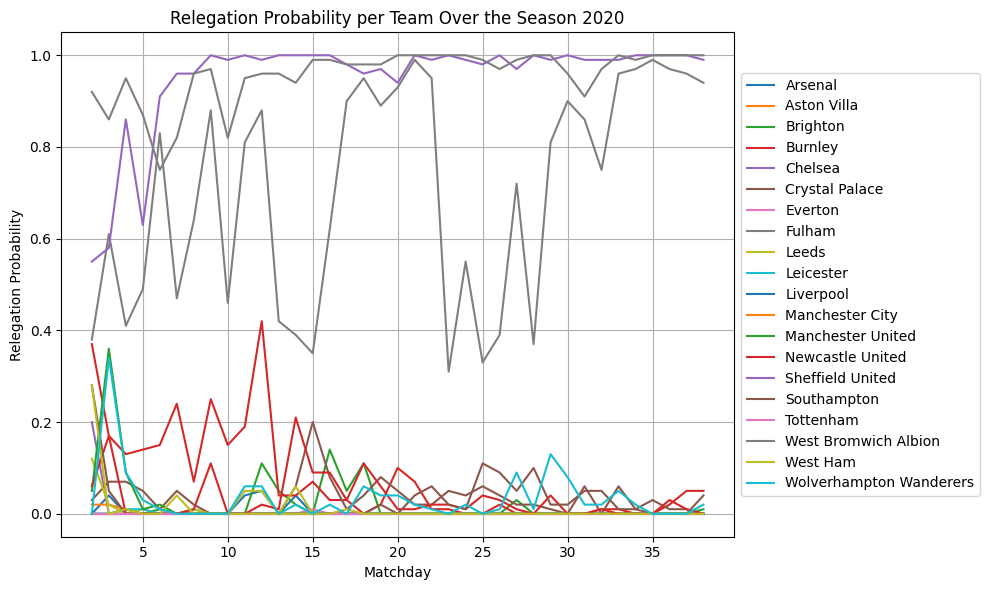

In [18]:
plt.figure(figsize=(10, 6))

for team in relegation_probs["name"].unique():
    team_data = relegation_probs[relegation_probs["name"] == team]
    plt.plot(team_data["matchday"], team_data["relegation_proba"], label=team)

plt.xlabel("Matchday")
plt.ylabel("Relegation Probability")
season = data.prem_data_collection.prem_season
plt.title(f"Relegation Probability per Team Over the Season {(season)}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# from RandomForest
importances = model.feature_importances_

# match them to column names
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)

                         Feature  Importance
10               points_per_game    0.326171
15              avg_player_value    0.152633
6                non-penalty xGD    0.110691
14               non-penality GD    0.091387
11               attack_strength    0.061743
1                        avg_age    0.059574
9         goal_difference_so_far    0.046682
2                     Foreigners    0.034555
0                     squad_size    0.031255
12                 defense_solid    0.024466
8   defending pressing intensity    0.017365
7             pressing intensity    0.016978
13              tactical_balance    0.009023
4                     cumsum_pts    0.008286
3                       matchday    0.005552
5                    cumsum_xpts    0.003638
